In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# 1. Загрузка данных

In [14]:
df = pd.read_csv("insurance.csv") 
print("shape:", df.shape)
display(df.head())

shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.1 Проверка пропусков и выбросов


Null counts:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

IQR outlier counts:
{'age': np.int64(0), 'bmi': np.int64(9), 'children': np.int64(0), 'charges': np.int64(139)}


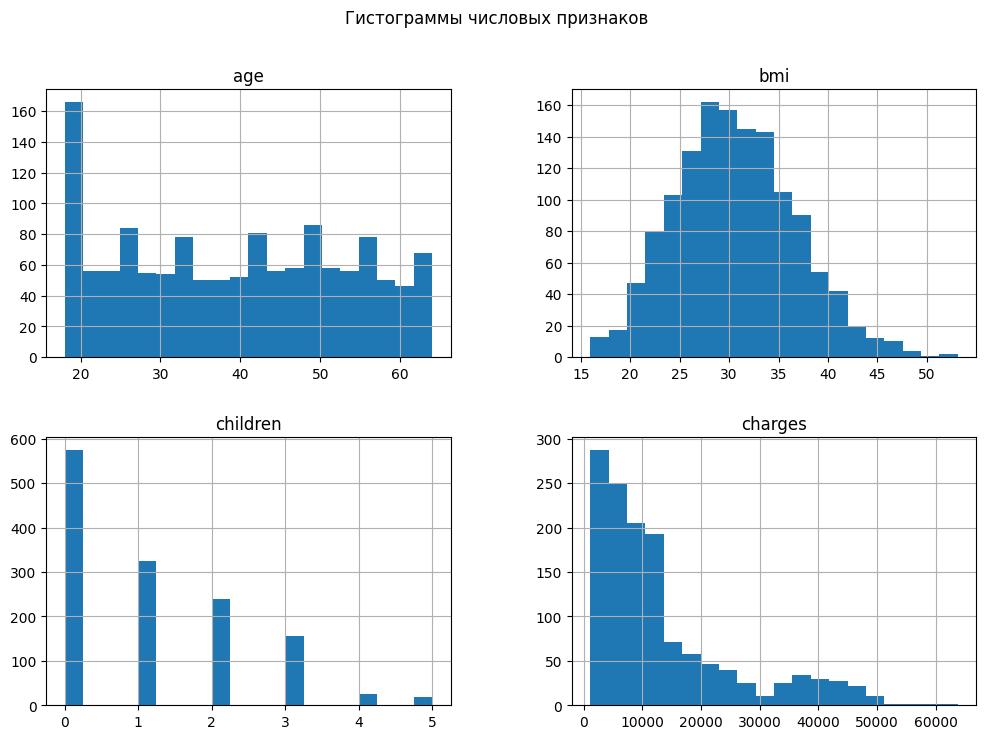

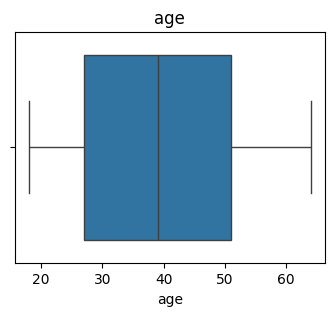

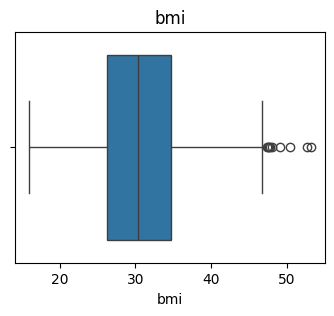

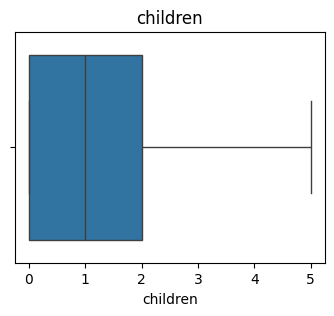

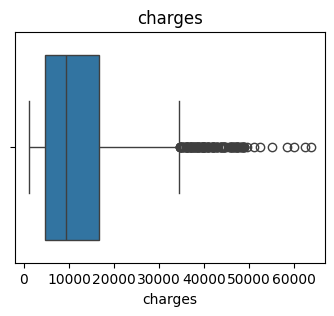

In [15]:
print("\nNull counts:")
print(df.isnull().sum())

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iqr_outliers = {}
for c in num_cols:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df[c] < lower) | (df[c] > upper)
    i_count = mask.sum()
    iqr_outliers[c] = i_count
print("\nIQR outlier counts:")
print(iqr_outliers)

# Гистограммы/ящики для визуального осмотра
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Гистограммы числовых признаков")
plt.show()

for c in num_cols:
    plt.figure(figsize=(4,3))
    sns.boxplot(x=df[c])
    plt.title(c)
    plt.show()

## 1.2 Кодирование категориальных признаков

In [16]:
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("\nКатегориальные признаки:", cat_cols)

df_enc = df.copy()

if 'sex' in df_enc.columns:
    df_enc['sex'] = (df_enc['sex'] == 'male').astype(int)

if 'smoker' in df_enc.columns:
    df_enc['smoker'] = (df_enc['smoker'] == 'yes').astype(int)

if 'region' in df_enc.columns:
    df_enc = pd.get_dummies(df_enc, columns=['region'], drop_first=True)

display(df_enc.head())


Категориальные признаки: ['sex', 'smoker', 'region']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


## 1.3 Попарные корреляции

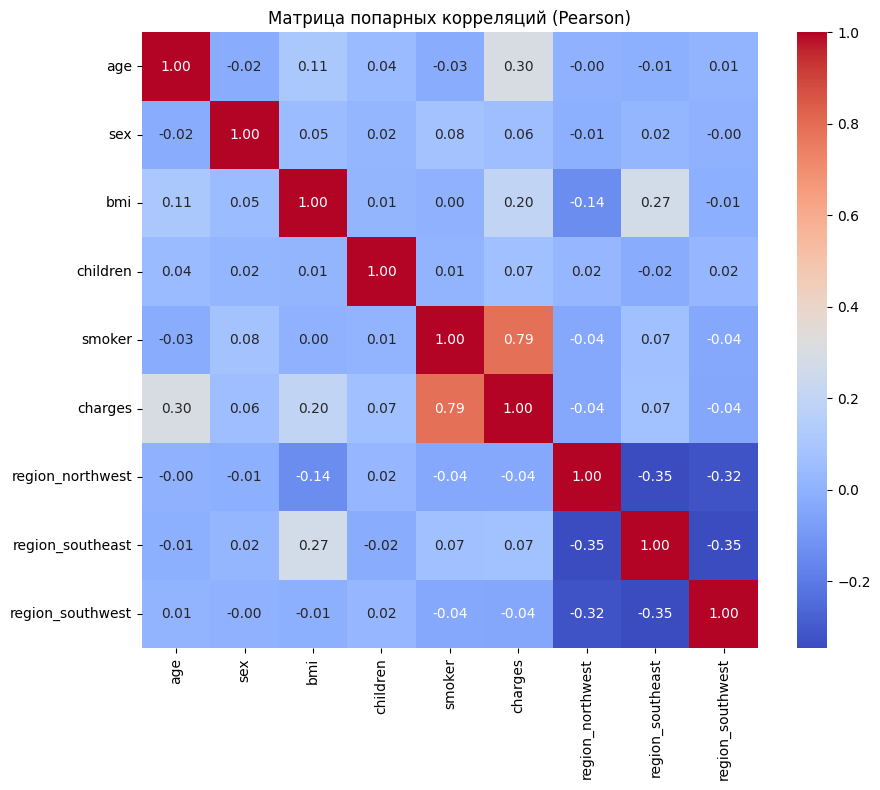


Корреляции признаков с 'charges':
charges             1.000000
smoker              0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex                 0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64


In [17]:
corr = df_enc.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Матрица попарных корреляций (Pearson)")
plt.show()

target = 'charges'
print("\nКорреляции признаков с 'charges':")
print(corr[target].sort_values(ascending=False))

### Подготовка X и y, стандартизация

In [18]:
X = df_enc.drop(columns=[target]).values
y = df_enc[target].values.reshape(-1,1)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

scaler = StandardScaler()
X_df = df_enc.drop(columns=[target])
num_idx = [X_df.columns.get_loc(c) for c in X_df.select_dtypes(include=[np.number]).columns]
X_scaled = scaler.fit_transform(X_df.values)

Xb = add_bias(X_scaled)  

X_train, X_test, y_train, y_test = train_test_split(Xb, y, test_size=0.2, random_state=42)

# 2. Многомерная линейная регрессия
## 2.1 Аналитически (нормальное уравнение)

In [19]:
def normal_equation(X, y, l2=0.0):
    n_features = X.shape[1]
    A = X.T @ X
    if l2 > 0:
        L = l2 * np.eye(n_features)
        L[0,0] = 0.0  # не регуляризируем bias
        A = A + L
    w = np.linalg.pinv(A) @ X.T @ y
    return w  # (n_features, 1)

w_analytic = normal_equation(X_train, y_train, l2=0.0)
print("Весы аналитически (без рег.):", w_analytic.ravel()[:5], "...")

def predict(X, w):
    return X @ w

Весы аналитически (без рег.): [ 1.33143359e+04  3.60914902e+03 -9.29533694e+00  2.05488506e+03
  5.12478869e+02] ...


## 2.2 Численно: градиентный спуск (batch)

Весы GD (первые 5): [ 1.33143359e+04  3.60914902e+03 -9.29533694e+00  2.05488506e+03
  5.12478869e+02]


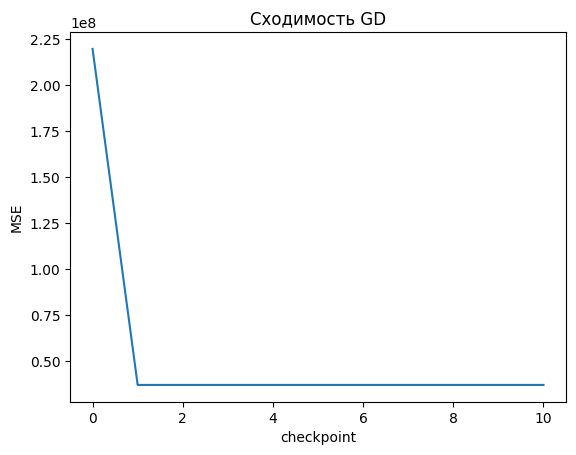

In [20]:
def mse_loss(X,y,w, l2=0.0):
    n = X.shape[0]
    preds = X @ w
    mse = ((preds - y)**2).mean()
    if l2>0:
        w_reg = w.copy()
        w_reg[0]=0.0
        mse += l2 * (w_reg**2).sum() / n
    return mse

def gradient_descent(X, y, lr=0.01, n_iter=1000, l2=0.0, verbose=False):
    n, d = X.shape
    w = np.zeros((d,1))
    history = []
    for i in range(n_iter):
        preds = X @ w
        grad = (2/n) * (X.T @ (preds - y))
        if l2>0:
            w_reg = w.copy()
            w_reg[0]=0.0
            grad += (2*l2/n) * w_reg
        w = w - lr * grad
        if i % (n_iter//10 + 1) == 0 or i==n_iter-1:
            history.append(mse_loss(X,y,w,l2))
            if verbose:
                print(f"iter {i}, loss {history[-1]:.4f}")
    return w, history

w_gd, hist = gradient_descent(X_train, y_train, lr=0.1, n_iter=5000)
print("Весы GD (первые 5):", w_gd.ravel()[:5])

# График сходимости
plt.plot(hist)
plt.xlabel("checkpoint")
plt.ylabel("MSE")
plt.title("Сходимость GD")
plt.show()

# 3. Добавление регуляризации (Ridge): аналитически и численно
## Аналитически (норм. уравнение с l2)

Ridge analytic first 5 weights: [ 1.33143773e+04  3.60555063e+03 -8.61916060e+00  2.05296126e+03
  5.12358230e+02]
Ridge GD first 5 weights: [ 1.33143773e+04  3.60555063e+03 -8.61916060e+00  2.05296126e+03
  5.12358230e+02]


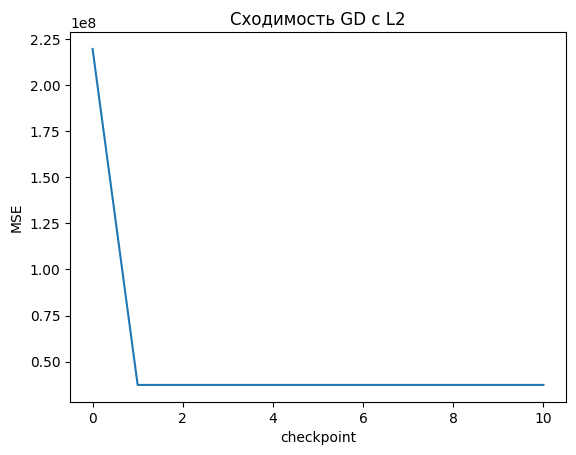

In [21]:
lambda_ = 1.0
w_ridge_analytic = normal_equation(X_train, y_train, l2=lambda_)
print("Ridge analytic first 5 weights:", w_ridge_analytic.ravel()[:5])

# Численно с l2
w_gd_ridge, hist_ridge = gradient_descent(X_train, y_train, lr=0.1, n_iter=5000, l2=lambda_)
print("Ridge GD first 5 weights:", w_gd_ridge.ravel()[:5])

plt.plot(hist_ridge)
plt.xlabel("checkpoint")
plt.ylabel("MSE")
plt.title("Сходимость GD с L2")
plt.show()

## Подбор λ через K-fold CV (простая сетка)

Best lambda (CV): 1.7782794100389228


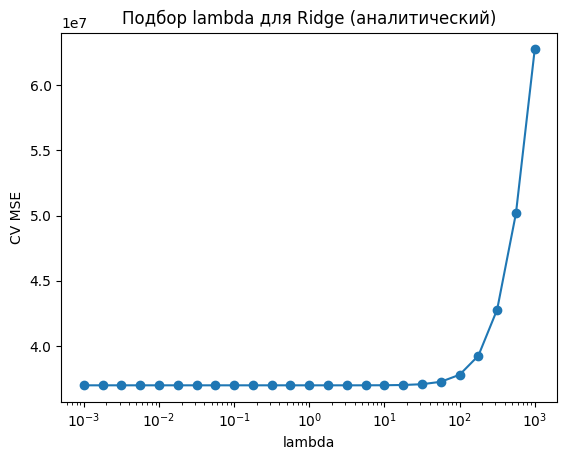

In [22]:
def cv_ridge_lambda(X, y, lambdas, K=5, lr=0.1, n_iter=2000):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    mean_mses = []
    for lam in lambdas:
        mses = []
        for train_idx, val_idx in kf.split(X):
            Xt, Xv = X[train_idx], X[val_idx]
            yt, yv = y[train_idx], y[val_idx]
            # аналитическое решение на train
            w = normal_equation(Xt, yt, l2=lam)
            preds = Xv @ w
            mses.append(((preds - yv)**2).mean())
        mean_mses.append(np.mean(mses))
    return mean_mses

lambdas = np.logspace(-3, 3, 25)
cv_mses = cv_ridge_lambda(Xb, y, lambdas, K=5)
best_lambda = lambdas[np.argmin(cv_mses)]
print("Best lambda (CV):", best_lambda)

plt.semilogx(lambdas, cv_mses, marker='o')
plt.xlabel("lambda")
plt.ylabel("CV MSE")
plt.title("Подбор lambda для Ridge (аналитический)")
plt.show()

# 4. Оценка обобщающей способности
## 4.1. Константный прогноз: среднее по train

In [23]:
mean_pred = y_train.mean()
mse_const = ((y_test - mean_pred)**2).mean()
print("MSE constant predictor:", mse_const)

MSE constant predictor: 155391443.68461317


## 4.2 Линейная из пункта 2 (аналитическая)

In [24]:
pred_analytic_test = predict(X_test, w_analytic)
mse_analytic = ((pred_analytic_test - y_test)**2).mean()
print("MSE linear analytic:", mse_analytic)

MSE linear analytic: 33596915.85136149


## 4.3 Ridge с лучшим lambda (аналитически)

In [25]:
w_best_ridge = normal_equation(X_train, y_train, l2=best_lambda)
pred_ridge_test = predict(X_test, w_best_ridge)
mse_ridge = ((pred_ridge_test - y_test)**2).mean()
print("MSE ridge (best lambda):", mse_ridge)

MSE ridge (best lambda): 33611344.62345938


In [26]:
# Сводная таблица
results = pd.DataFrame({
    'model': ['constant_mean', 'linear_analytic', 'ridge_analytic'],
    'mse': [mse_const, mse_analytic, mse_ridge]
})
print("\nResults:\n", results)

pred_gd_test = predict(X_test, w_gd)
mse_gd = ((pred_gd_test - y_test)**2).mean()
results = pd.concat([
    results,
    pd.DataFrame([{'model': 'linear_gd', 'mse': mse_gd}])
], ignore_index=True)
print("\nWith GD:\n", results)


Results:
              model           mse
0    constant_mean  1.553914e+08
1  linear_analytic  3.359692e+07
2   ridge_analytic  3.361134e+07

With GD:
              model           mse
0    constant_mean  1.553914e+08
1  linear_analytic  3.359692e+07
2   ridge_analytic  3.361134e+07
3        linear_gd  3.359692e+07


In [27]:
# Сохраним веса и scaler для дальнейшего использования
np.savez("linear_models.npz", w_analytic=w_analytic, w_gd=w_gd, w_ridge=w_ridge_analytic, scaler_mean=scaler.mean_, scaler_scale=scaler.scale_)
print("Done. Saved models to linear_models.npz")


Done. Saved models to linear_models.npz
